# Notebook for illustrating ill-conditioning of deconvolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from PIL import Image
from skimage.metrics import structural_similarity as ssim

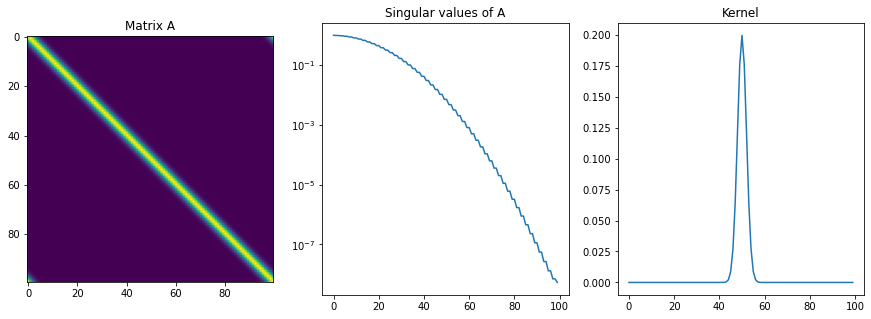

Relative error: 21932.88289702474


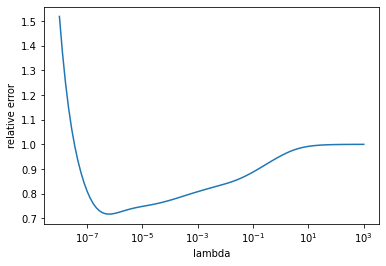

In [2]:
# matrix implementing circular convolution with a 1D-kernel
def conv_matrix_1d(kernel, n):
    m = len(kernel)
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(m):
            A[i, (i + j) % n] = kernel[j]
    return A

# 1D-Gaussian kernel centered at 0
def gaussian_kernel_1d(sigma, n):
    kernel = np.zeros(n)
    for i in range(n):
        kernel[i] = np.exp(-0.5 * (i - n // 2) ** 2 / sigma ** 2)
    return kernel / np.sum(kernel)

n = 100
kernel = gaussian_kernel_1d(2, 100)
# shift kernel by n//2 to center it
kernel_shifted = np.roll(kernel, n // 2)
A = conv_matrix_1d(kernel_shifted, n)

# plot matrix A, its singular values, and kernel next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(A)
ax[0].set_title('Matrix A')
ax[1].semilogy(np.linalg.svd(A, compute_uv=False))
ax[1].set_title('Singular values of A')
ax[2].plot(kernel)
ax[2].set_title('Kernel')
plt.show()

# get a random signal x 
x = np.random.randn(n)
# compute convolution of x with kernel
y = A @ x
# add noise to y
y_noisy = y + 0.001 * np.random.randn(n)
# deconvolve y_noisy
x_deconv = np.linalg.inv(A) @ y_noisy

# compute relative error    
print("Relative error:", np.linalg.norm(x - x_deconv) / np.linalg.norm(x))

# closed form solution to minimize ||Ax - y||^2 + lambda ||x||^2
def closed_form_solution(A, y, lam):
    return np.linalg.inv(A.T @ A + lam * np.eye(A.shape[1])) @ A.T @ y

# compute relative error for different values of lambda and store in list
rel_errors = []

# grid of log-spaced lambda values
lams = np.logspace(-8, 3, 100)

for lam in lams:
    x_deconv = closed_form_solution(A, y_noisy, lam)
    rel_errors.append(np.linalg.norm(x - x_deconv) / np.linalg.norm(x))

# plot relative error as a function of lambda
plt.semilogx(lams, rel_errors)
plt.xlabel('lambda')
plt.ylabel('relative error')
plt.show()


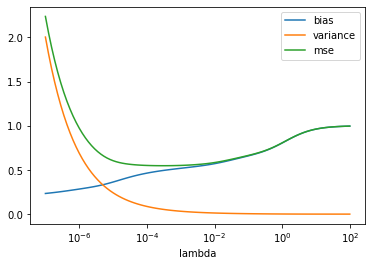

In [3]:
lams = np.logspace(-7, 2, 100)
noise_sigma = 0.01
xs = np.random.randn(n)
xs = xs / np.linalg.norm(xs)
# expected mean-squared error for different values of lambda
def bias(sigmas,lam,xs):
    return np.sum( np.array([ x**2 * (1 -  sigma ** 2 / (sigma ** 2 + lam))**2 for sigma,x in zip(sigmas,xs)]) )

def variance(sigmas,noise_sigma,lam):
    return noise_sigma**2 * np.sum( np.array([ (sigma / (sigma ** 2 + lam)) for sigma in sigmas]) )

# compute bias and variance for different values of lambda
sigmas = np.linalg.svd(A, compute_uv=False)
biases = [bias(sigmas,lam,xs) for lam in lams]
variances = [variance(sigmas,noise_sigma,lam) for lam in lams]
mse = np.array(biases) + np.array(variances)
# plot biases, variances, and mse as a function of lambda
plt.semilogx(lams, biases, label='bias')
plt.semilogx(lams, variances, label='variance')
plt.semilogx(lams, mse, label='mse')
plt.xlabel('lambda')
plt.legend()
plt.show()
